In [1]:
#!/usr/bin/env python
# coding: utf-8

import os
import ee
import io
import tqdm
import json
import fiona
import datetime
import requests
import urllib.request

import numpy as np
import xarray as xr
import pandas as pd
import rsfuncs as rs
import rasterio as rio
import geopandas as gp
import multiprocessing as mp

import matplotlib.pyplot as plt

from tqdm import tqdm
from affine import Affine
from datetime import timedelta
from rasterio import features, mask
from climata.usgs import DailyValueIO
from pandas.tseries.offsets import MonthEnd
from dateutil.relativedelta import relativedelta

ee.Initialize()

In [2]:
# Read catchments, reservoirs
gdf = gp.read_file("../shape/sierra_catchments.shp")
reservoirs_gdf = gp.read_file("../shape/reservoirs_grace.shp")

# Load rs data
data = rs.load_data()

# Define start / end
strstart = '2001-01-01'
strend = '2019-12-31'

startdate = datetime.datetime.strptime(strstart, "%Y-%m-%d")
enddate = datetime.datetime.strptime(strend, "%Y-%m-%d")

if not os.path.exists("../data/Budykodat/"):
    os.mkdir("../data/Budykodat/")


In [3]:
for idx, x in enumerate(gdf[:].iterrows()):
    print(idx)
    print("****" * 15)
    row  = x[1]
    stn_id = row['stid']
    print("PROCESSING {} ".format(stn_id))
    outfn = "../data/Budykodat/catch_{}.csv".format(stn_id)
    
    if not os.path.exists(outfn):
        # Get the RS data (EE)
        area = rs.gdf_to_ee_poly(gp.GeoDataFrame(gdf.loc[idx]).T)
        prism = rs.calc_monthly_sum(data['prism'], '1895-01-01', strend, area)
        modis_aet = rs.calc_monthly_sum(data['modis_aet'], strstart, strend, area)
        modis_pet = rs.calc_monthly_sum(data['modis_pet'], strstart, strend, area)

        prism.set_index(prism.index + MonthEnd(0), inplace = True)
        modis_aet.set_index(modis_aet.index + MonthEnd(0), inplace = True)
        modis_pet.set_index(modis_pet.index + MonthEnd(0), inplace = True)

        prism.columns = ['p_prism']
        modis_aet.columns = ['aet_modis']
        modis_pet.columns = ['pet_modis']

        # Build the out dataframe 
        mdf = pd.concat([prism,modis_aet, modis_pet],axis = 1)

        # Write
        outfn = "../data/Budykodat/catch_{}.csv".format(stn_id)

        mdf.to_csv(outfn)
    

0
************************************************************
PROCESSING NHG 
1
************************************************************
PROCESSING MCR 
2
************************************************************
PROCESSING NML 
3
************************************************************
PROCESSING ORO 
4
************************************************************
PROCESSING MIL 
5
************************************************************
PROCESSING FOL 
6
************************************************************
PROCESSING CFW 
7
************************************************************
PROCESSING DNP 
8
************************************************************
PROCESSING SHA 
9
************************************************************
PROCESSING SCC 
10
************************************************************
PROCESSING 11335000 
11
************************************************************
PROCESSING TRM 
12
******************************************

# Load data and plot

In [4]:
# Load files
files = [os.path.join("../data/Budykodat/",x) for x in os.listdir("../data/Budykodat/") if x.endswith(".csv")]

# Load shapefile of catchments
catchments = gp.read_file("../shape/sierra_catchments.shp")

# Load csvs as dataframes 
dfdict = {os.path.split(x)[-1][:-4]:pd.read_csv(x) for x in files}


In [5]:
budyko_dict = {}

for k,v in dfdict.items():
    stid = k.split("_")[1]
    catch = catchments[catchments['stid'] == stid]
    print("PROCESSING {} , catch area = {} KM2".format(catch.catch_name.values[0], catch.area_km2.values[0]))
    df = rs.col_to_dt(v)
    
    # Calc precip means from 1895 - 1960; 1960 - 2020:
    
    # Filter hydrologic years 1895 - 2018
    time_mask = (df.index > df.index[7]) & (df.index <= df.index[-4])
    adf = df[time_mask]
    
    threshdate = "1970-09-01"

    t1mask = (adf.index > adf.iloc[0].name) & (adf.index <= threshdate)
    t2mask = (adf.index > threshdate) & (adf.index <= adf.iloc[-1].name)
    
    pmean_t1 = adf[t1mask]['p_prism'].dropna().values.mean()
    pmean_t2 = adf[t2mask]['p_prism'].dropna().values.mean()
    
    # Get the AET and PET means 
    aet_mean = adf['aet_modis'].dropna().values.mean()
    pet_mean = adf['pet_modis'].dropna().values.mean()
    
    # Calc the params for budyko analysis
    p_aet1 = aet_mean / pmean_t1 
    p_pet1 = pet_mean / pmean_t1
    
    p_aet2 = aet_mean / pmean_t2 
    p_pet2 = pet_mean / pmean_t2 
        
    budyko_dict[catch.catch_name.values[0]] = [p_aet1, p_pet1, p_aet2, p_pet2]


PROCESSING BEAR R , catch area = 887.0472 KM2
PROCESSING COSUMNES , catch area = 1672.7633999999998 KM2
PROCESSING STANISLAUS R , catch area = 2801.79 KM2
PROCESSING FEATHER R , catch area = 11426.2893 KM2
PROCESSING AMERICAN R , catch area = 5838.2532 KM2
PROCESSING KAWEAH R , catch area = 1954.9593 KM2
PROCESSING TULE R , catch area = 1182.0492 KM2
PROCESSING CALAVERAS R , catch area = 1126.71 KM2
PROCESSING SACRAMENTO R , catch area = 24146.043299999998 KM2
PROCESSING KINGS R , catch area = 4702.4793 KM2
PROCESSING MERCED R , catch area = 3215.7486 KM2
PROCESSING YUBA R , catch area = 3495.3687 KM2
PROCESSING MOKELUMNE R , catch area = 1771.0973999999999 KM2
PROCESSING KERN R , catch area = 6221.0511 KM2
PROCESSING TUOLUMNE R , catch area = 4722.405299999999 KM2
PROCESSING SAN JOAQUIN R , catch area = 5003.086499999999 KM2


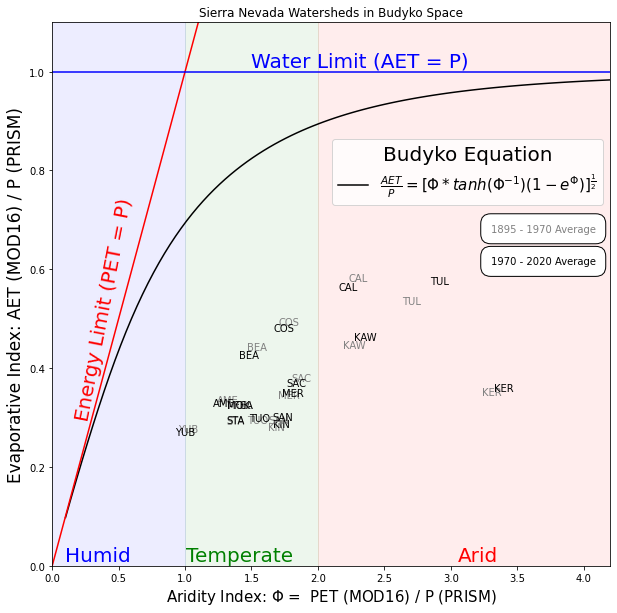

In [6]:
# Budyko plot

plt.figure(figsize = (10,10))

for k,v in budyko_dict.items():
    
    basinstr = k.split()[0]
    
    plt.scatter(v[1],v[0],alpha = 0.)
    plt.text(v[1], v[0], basinstr[:3], fontsize = 10, color = 'gray')
    
    plt.scatter(v[3],v[2],alpha = 0.)
    plt.text(v[3], v[2], basinstr[:3], fontsize = 10, color = 'black')
    
# Ploy budyko equation shown above
budyko_x = np.linspace(0.1, 4.2, 100)
budyko_y = np.array([np.sqrt((x*np.tanh(x**-1)*(1-np.exp(-x)))) for x in budyko_x])
plt.plot(budyko_x,budyko_y, color = 'black',
         label = r'$ \frac{AET}{P}  = [{\Phi * tanh(\Phi^{-1}) (1-e^{\Phi})}]^{\frac{1}{2}} $')

# Put budyko eq in legend
plt.legend(bbox_to_anchor=[1, 0.65], loc='lower right', fontsize = 15, title = "Budyko Equation", title_fontsize = 20)

# Add info about the plots
plt.annotate("1895 - 1970 Average", (0.88, 0.62),
             xycoords="axes fraction", va="center", ha="center", color = 'gray',
             bbox=dict(boxstyle="round, pad=1", fc="w")) 

plt.annotate("1970 - 2020 Average", (0.88, 0.56),
             xycoords="axes fraction", va="center", ha="center", color = 'black',
             bbox=dict(boxstyle="round, pad=1", fc="w")) 

# Plot water and energy limits
plt.plot([-10,10],[-10,10],  color='r', linestyle='-')
plt.axhline(y=1, color='blue', linestyle='-')

plt.text(1.5,1.01, 'Water Limit (AET = P)', color = 'blue', size = 20)
plt.text(0.16,0.3, 'Energy Limit (PET = P)', color = 'red', size = 20, rotation = np.degrees(np.pi/2.28))

# Plot shaded climate zones 
plt.axvspan(0, 1, alpha=0.07, color='blue')
plt.axvspan(1, 2, alpha=0.07, color='green')
plt.axvspan(2, 4.5, alpha=0.07, color='red')

plt.text(0.1,0.01, 'Humid', color = 'blue', size = 20)
plt.text(1.01,0.01, 'Temperate', color = 'green', size = 20)
plt.text(3.05,0.01, 'Arid', color = 'red', size = 20)

plt.ylabel("Evaporative Index: AET (MOD16) / P (PRISM)", size = 17)
plt.xlabel(r"Aridity Index: $\Phi$ =  PET (MOD16) / P (PRISM)", size = 15)

plt.ylim([0,1.1])
plt.xlim([0,4.2])

plt.title("Sierra Nevada Watersheds in Budyko Space")
plt.show()